# Import librairies

In [40]:
from gensim import corpora
from gensim import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd

from motifs.dataloader import CanonData
from motifs.features import bow_to_matrix
from motifs.utils import filter_token_by_freq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from motifs.pipeline import Pipeline
from motifs.features import build_tfidf, transform_corpus_to_ngrams
from motifs.utils import build_window_corpus, return_to_text_from_token

# Load data

- Get metadata
- Load the 5-grams that were precomputed using a subcorpus of the "canon" corpus.
    - This subcorpus was built by selecting at most 50 texts at random per period, which are defined in `motifs.dataloader.CanonData`, e.g 1800-1826, 1827-1850, 1851-1869, 1870-1899, 1900-1945, 1946-2024.
    - We have in total 217 documents
    - Remove tokens that appear only once in each document in the corpus

In [2]:
NGRAMS_PATH = "/Users/brunospilak/Documents/Sorbonne/PyMotifs/data_backup/ngrams_canon.csv"
METADATA_PATH = "../data/canon/metadata.csv"

In [3]:
# Load metadata
metadata = CanonData(METADATA_PATH)
data = metadata.data.set_index("doc_id")

# Load 5-grams, about 1.6GB in RAM
ngrams = pd.read_csv(NGRAMS_PATH, index_col=0)
docs = list(set(ngrams.doc.unique()))
# Get the metadata for the subcorpus
data = data.loc[docs]

# Remove tokens that appear only once, this can take a while since ngrams has more than 15 Million rows
t1 = time.time()
ngrams = filter_token_by_freq(ngrams, 1, groupby="doc")
t2 = time.time()
print(f"Done in {t2-t1:.2f} secs")

Done in 74.26 secs


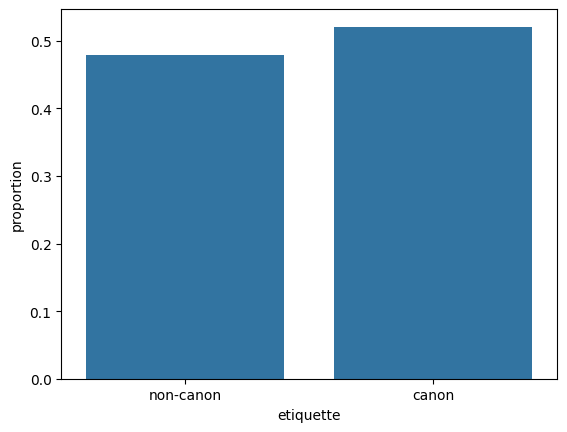

,doc,token,word,text,target
0,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les regards de les agens,non-canon
1,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,le,le nom de le conseil,non-canon
2,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,la,la bienfaisance de le dieu,non-canon
3,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les habitans de le royaume,non-canon
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,le NC de le NC,les,les fers de l' étranger,non-canon
...,...,...,...,...,...
4848684,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC de,serait,serait un vrai coup de,non-canon
4848685,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un charmant garçon que,non-canon
4848686,1971_Veuzit-Max-du_Rien-qu'une-nuit,être un ADJ NC que,est,est un vrai roman que,non-canon
4848687,1971_Veuzit-Max-du_Rien-qu'une-nuit,"être un NC , un",est,"est une bombe , un",non-canon


In [4]:
# Add target variable
sns.countplot(data, x="etiquette", stat="proportion")
plt.show()
ngrams = ngrams.set_index("doc").join(data["etiquette"]).reset_index().rename({"etiquette": "target"}, axis=1)
ngrams

# Train/test split

We split with respect to the documents, having different document in train and test, but keeping the class distribution in train and test samples.

In [5]:
test_size = 0.3
random_state = 0 # For reproducibility
# Use StratifiedShuffleSplit to keep class balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
train_docs, test_docs = list(sss.split(data.index, data.etiquette))[0]
train_docs = data.index[train_docs].tolist()
test_docs = data.index[test_docs].tolist()
print(len(train_docs), len(test_docs))

t1 = time.time()
train_data = ngrams[ngrams["doc"].isin(train_docs)]
test_data = ngrams[ngrams["doc"].isin(test_docs)]
t2 = time.time()
print(f"{t2-t1:.2f}")

151 66
0.54


# Featurization (TFIDF)

In [6]:
## Train set
t1 = time.time()
train_tfidf, model, dictionary = build_tfidf(train_data, normalize=False, smartirs="nfn")
t2 = time.time()
print(f"{t2-t1:.2f}")

# Test set
t1 = time.time()
test_tfidf, _, _ = build_tfidf(test_data, model=model, dictionary=dictionary, normalize=False, smartirs="nfn") # Use train_idf
t2 = time.time()
print(f"{t2-t1:.2f}")

37.89
12.99


In [7]:
# Transform to a table with documents as indices and tokens as columns
t1 = time.time()
train_tfidf = train_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")
t1 = time.time()
test_tfidf = test_tfidf.pivot_table(values="tfidf", columns="token", index="doc")
t2 = time.time()
print(f"{t2-t1:.2f}")

(train_tfidf.shape, test_tfidf.shape)

26.89
13.86


((151, 232300), (66, 286754))

In [8]:
# Remove new tokens and add missing ones in the test set
if set(train_tfidf.columns) != set(test_tfidf.columns):
    missing_features_in_test = pd.DataFrame(0, columns=list(set(train_tfidf.columns) - set(test_tfidf.columns)), index=test_tfidf.index)
    test_tfidf = pd.concat([test_tfidf, missing_features_in_test], axis=1)
    test_tfidf = test_tfidf[train_tfidf.columns]
    
    missing_features_in_train = list(set(test_tfidf.columns) - set(train_tfidf.columns))
    if len(missing_features_in_train):
        # Remove new features in test set (they are equal to 0 anyway)
        test_tfidf.drop(missing_features_in_train, axis=1, inplace=True)
(train_tfidf.shape, test_tfidf.shape)

((151, 232300), (66, 232300))

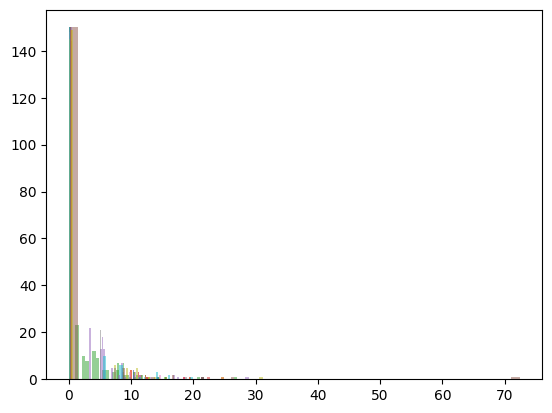

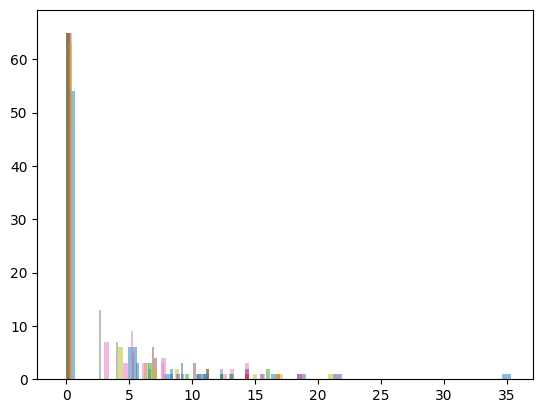

In [13]:
for _ in range(100):
    plt.hist(train_tfidf.iloc[:, np.random.randint(train_tfidf.shape[-1])],
             bins=50, alpha=0.5)
plt.show()
for _ in range(100):
    plt.hist(test_tfidf.iloc[:, np.random.randint(test_tfidf.shape[-1])],
             bins=50, alpha=0.5)
plt.show()

## we obtain more than 200K features, that is too many! We must introduce a criterion for feature selection.

Since we know that a token which as a tfidf of 0 corresponds to non-informative tokens, we propose a simple solution solution based on the sparsity of each column of the `train_features` matrix. We define the sparsity level as the proportion of 0 in a column of a matrix ($\forall j, \operatorname{S}_j = 1/n\sum_i \operatorname{I}\{M_{ij} = 0\}$ where $n$ is the number of rows in matrix $M$ and $j$ represents a token as column). The more sparse the column of a token, the less informative is the token within the corpus, since it is more common to all documents. Then, we simply select the $n$ less sparse features.

In [52]:
n = 1000
to_keep = sparsity.sort_values()[:n].index
selected_train = train_tfidf[to_keep]
selected_test = test_tfidf[to_keep]

# Add categorical features

We include the *author*, *period*, and *gender* variables. *author* and *period* are encoded as one-hot features, while *gender* is a binary variable.

In [270]:
one_hot_features = data[["period"]]
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

train_x = one_hot_encoder.fit_transform(one_hot_features.loc[train_tfidf.index])
cols = [f"period_{i}" for i in one_hot_encoder.categories_[0]]
train_x = pd.DataFrame(train_x.toarray(), columns=cols, index=train_tfidf.index)
train_x["gender"] = (data["sexe"] == "female").astype(int).loc[train_tfidf.index]

test_x = one_hot_encoder.transform(one_hot_features.loc[test_tfidf.index])
test_x = pd.DataFrame(test_x.toarray(), columns=cols, index=test_tfidf.index)
test_x["gender"] = (data["sexe"] == "female").astype(int).loc[test_tfidf.index]

train_x = pd.concat([train_x, selected_train], axis=1)
test_x = pd.concat([test_x, selected_test], axis=1)

print(train_x.shape, test_x.shape)

(151, 1007) (66, 1007)


# Normalization

We propose to perform a MinMax scaling of the feature in the range [0,1] to ease the interpretation of the regession coefficient.

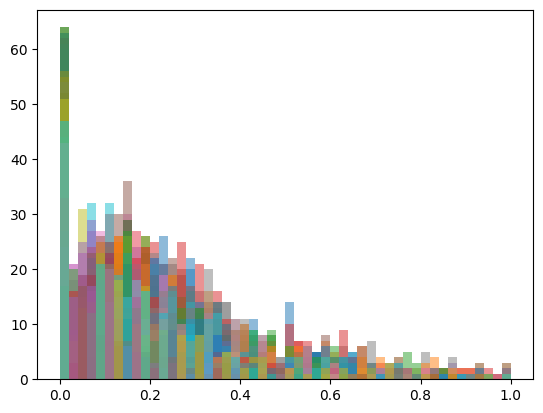

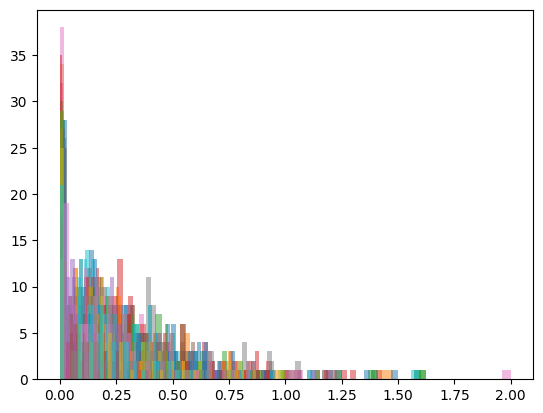

In [279]:
scaler = MinMaxScaler(feature_range=(0,1))
train_features = scaler.fit_transform(train_x)
test_features = scaler.transform(test_x)

x = []
for _ in range(100):
    i = np.random.randint(train_features.shape[-1])
    x.append(i)
    plt.hist(train_features[:, i],
             bins=50, alpha=0.5)
plt.show()
for i in range(100):
    plt.hist(test_features[:, x[i]],
             bins=50, alpha=0.5)
plt.show()


# Target variable

In [280]:
target = (data["etiquette"] == "canon").astype(int)
train_y = target.loc[train_tfidf.index].astype(int)
test_y = target.loc[test_tfidf.index].astype(int)

# Fit the model

In [281]:
# Since we have a still a lot of features (1091) compared to the number of observations (151), we propose to use a L1 regularization to select the most important features
# It introduces one hyperparameter: C (the strength of the penalty).
# It will force many parameters to be 0, which introduce sparsity in the solution, thus it is easier to interpret
clf = LogisticRegression(solver='liblinear', penalty='l1', C=0.9, random_state=random_state)
clf.fit(train_features, train_y)

print("Train accuracy", clf.score(train_features, train_y) * 100)
print("Test accuracy", clf.score(test_features, test_y) * 100)
print("Sparisty", np.mean(clf.coef_ == 0) * 100)

Train accuracy 93.37748344370861
Test accuracy 77.27272727272727
Sparisty 96.42502482621649


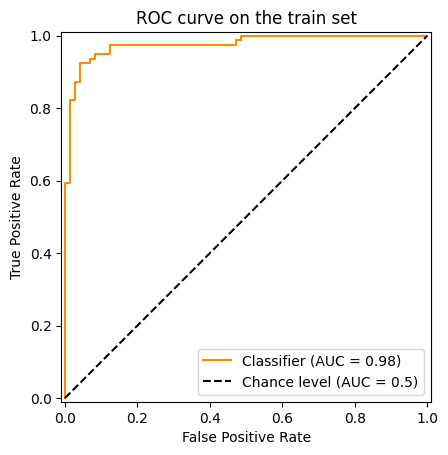

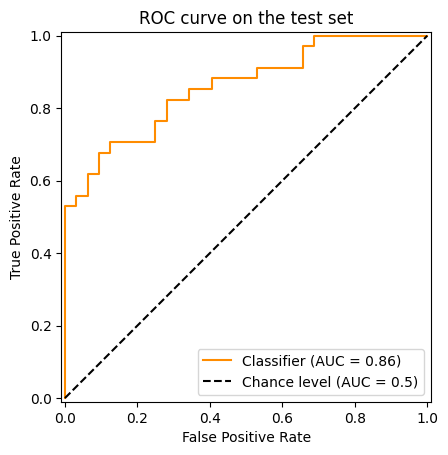

In [282]:
train_y_proba = clf.predict_proba(train_features)
display = RocCurveDisplay.from_predictions(
    train_y,
    train_y_proba[:, 1],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve on the train set",
)

test_y_proba = clf.predict_proba(test_features)
display = RocCurveDisplay.from_predictions(
    test_y,
    test_y_proba[:, 1],
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve on the test set",
)

We obtain an accuracy of 78,8% on the test set showing that we can classify realtively well whether a document is a canon or not based on the motifs and metadata. The classifier does not perfectly predict the target variable on the train set, probably because of the L1 regularization.

On top the ROC curves and AUC of 0.89 on the set show that the predicted probability scores are well calibrated. Since the classes are balanced, the default probability class threshold of 0.5 is likely a good choice.

# Features' importance

36


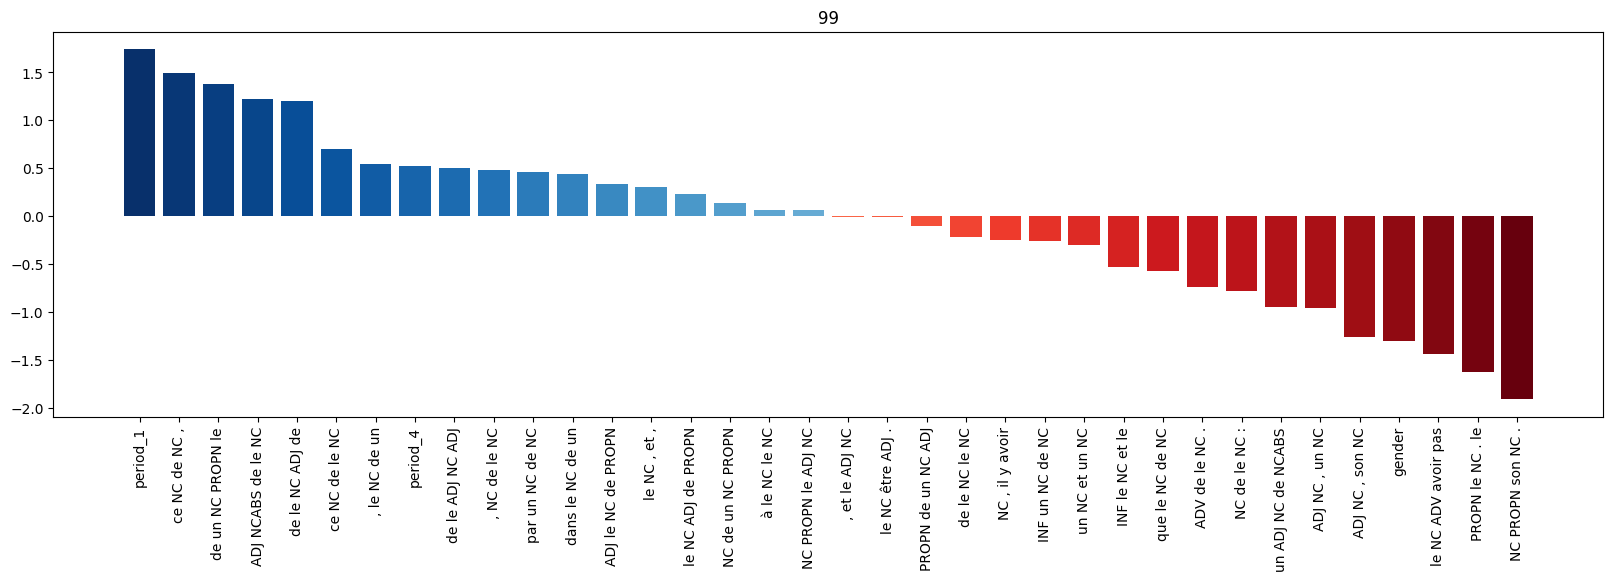

In [284]:
coefs = pd.Series(clf.coef_[0,:], index=train_x.columns)
selected_features = coefs[coefs != 0].sort_values(ascending=False)
print(len(selected_features))
# Separate positive and negative values
positive_values = [val if val > 0 else 0 for val in selected_features]
negative_values = [val if val < 0 else 0 for val in selected_features]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20,5))

# Plot positive values with varying shades of blue
ax.bar(range(len(positive_values)), positive_values, color=plt.cm.Blues(np.linspace(0, 1, len(positive_values)))[::-1])

# Plot negative values with varying shades of red
ax.bar(range(len(negative_values)), negative_values, color=plt.cm.Reds(np.linspace(0, 1, len(negative_values))))

# Customize the plot
ax.set_xticks(range(len(selected_features)))
ax.set_xticklabels(selected_features.index, rotation=90)
ax.set_title(i)
plt.show()

The lasso has selected 36 features: some motifs but also 4 authors (G. Sand, A. Dumas (père), H. de Balzac, and J. Verne), the gender variable, and 3 periods (1827-1850, 1851-1869, and 1900-1945).

In our corpus, writings by G. Sand are more likely to be regarded as canonical compared to those of other authors. Similarly, A. Dumas (père) and H. de Balzac have a strong positive impact on the likelihood of a document to be classified as canonical.

On the other hand, the gender of the author has a negative influence on the probability of a document to be considered canonical in our corpus. Since we encoded female as 1, writings by female authors are more liekly to be regarded as non-canonical compared to those of male authors.

Finally, the periods 1827-1850 and 1900-1945 have both a positive impact on the target, while the period 1851-1869 a negative one.

Let us remind that these interpretation are based on correlation only which cannot be extrapolated as causation. A priori, the gender of the author should have no impact on the etiquette of his/her writings.

# Error analysis

In [174]:
from sklearn.metrics import classification_report, confusion_matrix

In [175]:
print(classification_report(test_y, test_y_pred))
print(confusion_matrix(test_y, test_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        32
           1       0.78      0.82      0.80        34

    accuracy                           0.79        66
   macro avg       0.79      0.79      0.79        66
weighted avg       0.79      0.79      0.79        66

[[24  8]
 [ 6 28]]


It seems that the type I and II errors are well balanced.

In [182]:
test_y_pred = clf.predict(test_features)
correct = test_y.index[test_y_pred == test_y]
errors = test_y.index[test_y_pred != test_y]

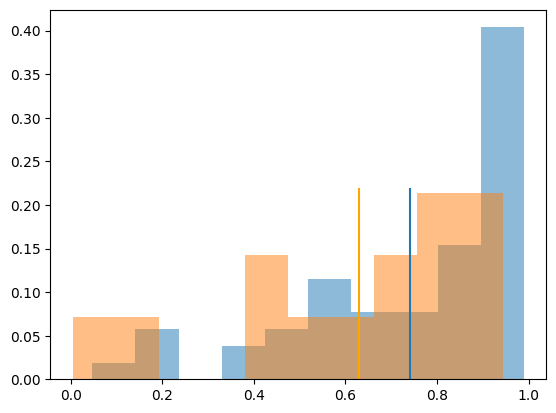

In [204]:
plt.hist(
    (selected_test.loc[correct] != 0).sum(axis=1) / selected_test.shape[-1], 
    alpha=0.5, 
    weights=np.ones(len(correct)) / len(correct)
)
plt.vlines(np.mean((selected_test.loc[correct] != 0).sum(axis=1) / selected_test.shape[-1]), 0, 0.22)

plt.hist(
    (selected_test.loc[errors] != 0).sum(axis=1) / selected_test.shape[-1],
    alpha=0.5,
    weights=np.ones(len(errors)) / len(errors)
)
plt.vlines(np.mean((selected_test.loc[errors] != 0).sum(axis=1) / selected_test.shape[-1]), 0, 0.22, 
           color="Orange")

The TFIDF features seem to be more sparse in the wrongly classified documents

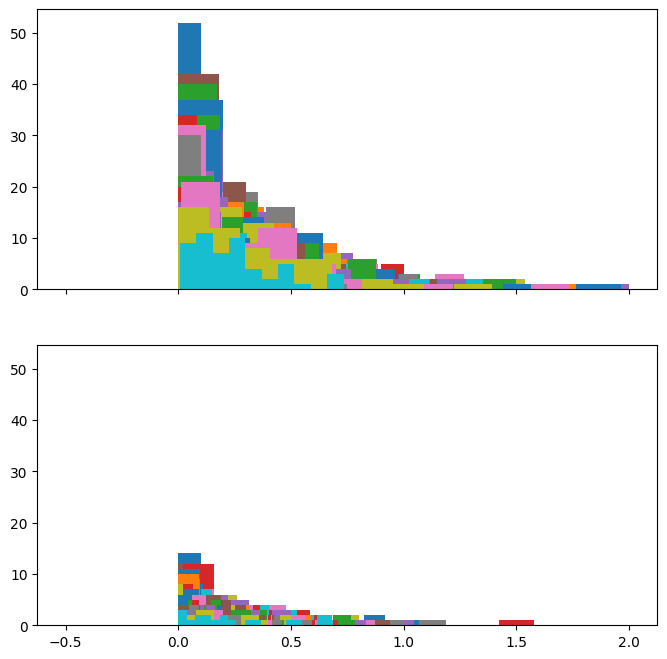

In [243]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
for i in range(len(selected_test.columns)):
    axs[0].hist(test_features[selected_test.index.isin(correct), -i])
for i in range(len(selected_test.columns)):
    axs[1].hist(test_features[selected_test.index.isin(errors), -i])
plt.show()

## FP/FN

In [244]:
fp = test_y.index[(test_y_pred==1) & (test_y==0)]
fn = test_y.index[(test_y_pred==0) & (test_y==1)]
data.loc[fp]

,titre,author,sexe,birth_date,death_date,date_publication,etiquette,period
doc,,,,,,,,
1836_Igonette-T._Le-Valmont-de-la-jeunesse-ou-le-Triomphe-des-vertus-sur-les-egarements-de-la-raison-mis-a-la-portee-des-jeunes-gens-des-deux-sexes-par-T-Igonette-tome-1,"Le Valmont de la jeunesse, ou le Triomphe des ...","Igonette, T.",unknown,1???,1???,1836,non-canon,1
1880_Ulbach-Louis_Le-Chateau-des-Epines,"Le Château des Épines, par Louis Ulbach (1880)","Ulbach, Louis",male,1822,1889,1880,non-canon,3
1903_Leblanc-Maurice_Un-gentleman,Un gentleman,"Leblanc, Maurice",male,1864,1941,1903,non-canon,4
1906_Le-Rouge-Gustave_La-Reine-des-elephants,La Reine des éléphants,"Le Rouge, Gustave",male,1867,1938,1906,non-canon,4
1907_Vanderem-Fernand_La-victime,La victime,"Vandérem, Fernand",male,1864,1939,1907,non-canon,4
1920_Leblanc-Maurice_Les-trois-yeux,Les trois yeux,"Leblanc, Maurice",male,1864,1941,1920,non-canon,4
1926_Hemon-Louis_Battling-Malone-pugiliste,"Battling Malone, pugiliste","Hémon, Louis",male,1880,1913,1926,non-canon,4
1927_Leblanc-Maurice_L-Homme-a-la-peau-de-bique,L'Homme à la peau de bique,"Leblanc, Maurice",male,1864,1941,1927,non-canon,4


From the metadata, we can say that FP seems to be documents written mostly by male authors published in the period 4 that is 1900-1945. We know that on average, documents written by male and the ones published during this period have more chance to be classified as canonical by our predictor. We would probably need to include more variables to correctly classify these examples.

In [251]:
data.loc[fn]

,titre,author,sexe,birth_date,death_date,date_publication,etiquette,period
doc,,,,,,,,
1825_Duras-Claire-de_Edouard,Edouard,"Duras, Claire (de)",female,1777,1828,1825,canon,0
1855_Nerval-Gerard-de_Aurelia,Aurélia,"Nerval, Gérard de",male,1855,1855,1855,canon,2
1858_Sand-George_Les-beaux-messieurs-de-Bois-Dore-1,Les beaux messieurs de Bois Dore 1,"Sand, George",female,1804,1876,1858,canon,2
1895_France-Anatole_Le-Puit-de-Sainte-Claire,Le Puit de Sainte Claire,"France, Anatole",male,1844,1924,1895,canon,3
1896_Schwob-Marcel_Vies-imaginaires,Vies imaginaires,"Schwob, Marcel",male,1867,1905,1896,canon,3
1904_Verne-Jules_Un-drame-en-Livonie,Un drame en Livonie,"Verne, Jules",male,1828,1905,1904,canon,4


From the metadata, it is difficult to interpret the False Negatives, however we notice two documents written by female authors. We know that on average, documents written by female have less chance to be classified as canonical by our predictor.

In [254]:
data.groupby("author")["etiquette"].value_counts()

author                                 etiquette
About, Edmond                          non-canon    2
Aimard, Gustave                        non-canon    1
Albalat, Antoine                       non-canon    1
Apollinaire, Guillaume                 canon        2
Arlincourt, Charles-Victor Prévost d'  non-canon    1
                                                   ..
Verne, Jules                           canon        5
Vesco, Marie Delorme, Mme Léon         non-canon    1
Villiers de l'Isle-Adam, Auguste       canon        2
Zola Emile                             canon        1
Zola, Émile                            canon        2
Name: count, Length: 113, dtype: int64

In [263]:
data["sexe"].value_counts()

sexe
male       162
female      51
unknown      3
Name: count, dtype: int64

In [265]:
crosstab_cluster_y = pd.crosstab(data["sexe"].astype("category"), data["etiquette"].astype("category"))
crosstab_cluster_y

etiquette,canon,non-canon
sexe,,
female,10,41
male,103,59
unknown,0,3
